# Quantum kernel and support vector machines

To develop quantum machine learning it is necessary to know these elementary concepts: how to convert classical data into quantum data through quantum feature maps and how to run quantum neural networks with quantum kernels and quantum support vector machines. Today we delve into all these concepts and draw solid conclusions.

## Data

The data we are going to work with today will be a small subset of the well known handwritten `digits dataset`, which is available through scikit-learn. We will be aiming to differentiate between '0' and '1'.

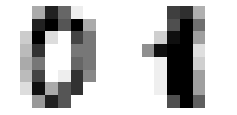

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import *

# Load digits dataset 
# setting 'nclass = 2' select only images associated with 0 and 1
digits = datasets.load_digits(n_class = 2)

# Plot example o and 1
fig,axs = plt.subplots(1,2,figsize = (4,2))
axs[0].set_axis_off()
axs[0].imshow(digits.images[0], cmap = plt.cm.gray_r, interpolation = 'nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[1], cmap = plt.cm.gray_r, interpolation = 'nearest')
plt.show()

## Data procesing 

There are total of 360 datapoints in the dataset. Each datapoint is a 8x8 image of a digit, collapsed into an array, where each element is an integer between 0 (white) and 16 (black). As per classical classification, we need to split the dataset into training (100) and teasting (20) samples, and normalise it. To use the dataset for quantum classification, we need to scale the range between -1 and 1, and reduce the dimensionality to the number of qubits we want to use (4), otherwise de dimensionality would be equivalent to a large number of qubits, too much to use in a simulator or a real quantum computer, which would also take too long to execute the problem.

In [54]:
# Split dataset into train and test
from sklearn.model_selection import train_test_split
sample_train, sample_test, label_train, label_test = train_test_split(
    digits.data, digits.target, test_size = 0.2, random_state = 22)

# Reduce dimensions from 8x8 = 64 to 4x2 = 16
from sklearn.decomposition import PCA
n_dim = 4
pca = PCA(n_components = n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise from 0-16 to -1-1
# StandardScale() transforms our data into another dataset with mean 0 and variance 1
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
from sklearn.preprocessing import MinMaxScaler
samples = np.append(sample_train, sample_test, axis = 0)
minmax_scale = MinMaxScaler((-1,1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)


# Select 
train_size = 100
sample_train = sample_train[:train_size] 
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size] 
label_test = label_test[:test_size]

print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209] 0
[ 0.41948352 -0.83602799  0.72200828 -0.373356  ] 1


## Data encoding

We will take the clasical data and encode it to the quantum state space using a quantum feature map. the choice of which feature map to use is important and may depend on the given dataset we want to classify. Here we will look at the feature maps aviable in qiskit, before selecting and customising one to encode our data.

**Quantum Feature Map**

As the name suggest, a quantum feature map $\varphi(x)$ is a map from the classical feature vector x to the quantum state $|\varphi(x)\rangle\langle\varphi(x)|$, a vector in Hilber space. This is faciliated by appling the unitary operator $U_{\varphi(x)}$ on the initial state $|0\rangle^{n}$.

 

<ul> The feature maps current aviable in qiskit are:
    <li> `PauliFeatureMap`</li>
    <li> `ZZFeatureMap`</li>
    <li> `ZFeatureMap`</li>
</ul>

In particular, `ZZFeaturemap` is ocnjectured to be hard to simulate classically and can be implemented as short-depth circuits and near-term quantum devices.

In [55]:
# Import standard QisKit libraries
from qiskit import *
from qiskit.visualization import *
from qiskit.quantum_info import *
from qiskit.circuit.library import *
from qiskit.opflow import *

# Load IBM Quantum account
from qiskit import IBMQ
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-05-04 13:05:22,640: Credentials are already in use. The existing account in the session will be replaced.


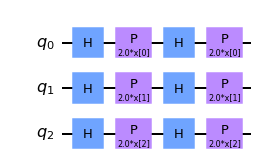

In [56]:
# Note that this feature map is non-entanglement, which implies that it has no advantage over a classical treatment.

map_z = ZFeatureMap(feature_dimension = 3, reps = 2)
map_z.decompose().draw('mpl')

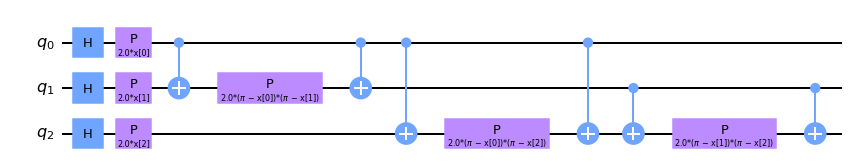

In [57]:
# However, ZZFeatureMap has entanglement, which implies an advantage over the classical treatment.

map_zz = ZZFeatureMap(feature_dimension = 3, reps = 1)
map_zz.decompose().draw('mpl')

The `NLocal`and `TwoLocal` in qiskit's circuit library can also be used to create parametrised quantum circuits as feature maps. 
both functions create parametrised circuits of alternation and entanglement layers. In both layers, parametrised circuits-blocks act on a circuit in a defined way. Rotation block are applied stacked while entanglement block applied according to the input parameter, and by default a final rotation layer is appended.

In `NLocal` the circuit blocks can have arbitrary sizes, while in `TwoLocal` the rotation layers are single qubit gates applied on all qubits and the entanglement layer use two qubit gates.

for example, here is `TwoLocal` circuit, with $R_{x}$ and $R_{y}$ gates in the rotation layer and $CX$ gates in the entangling layer with circular entanglement.

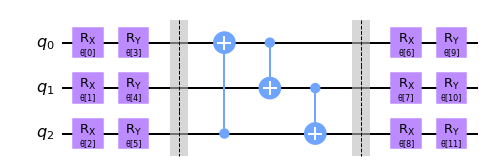

In [58]:
twolocal = TwoLocal(num_qubits=3, reps = 1, rotation_blocks= ['rx','ry'],
                    entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.decompose().draw('mpl')

And the equivalent `NLocal` circuit:

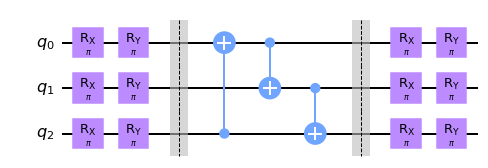

In [59]:
nlocal = NLocal(num_qubits=3, reps=1, 
                rotation_blocks=[RXGate(np.pi), RYGate(np.pi)],
                entanglement_blocks=CXGate(),
                entanglement='circular',
                insert_barriers=True)
nlocal.decompose().draw('mpl')

**First training sample using ZZFeatureMap**

In [60]:
print(sample_train[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]


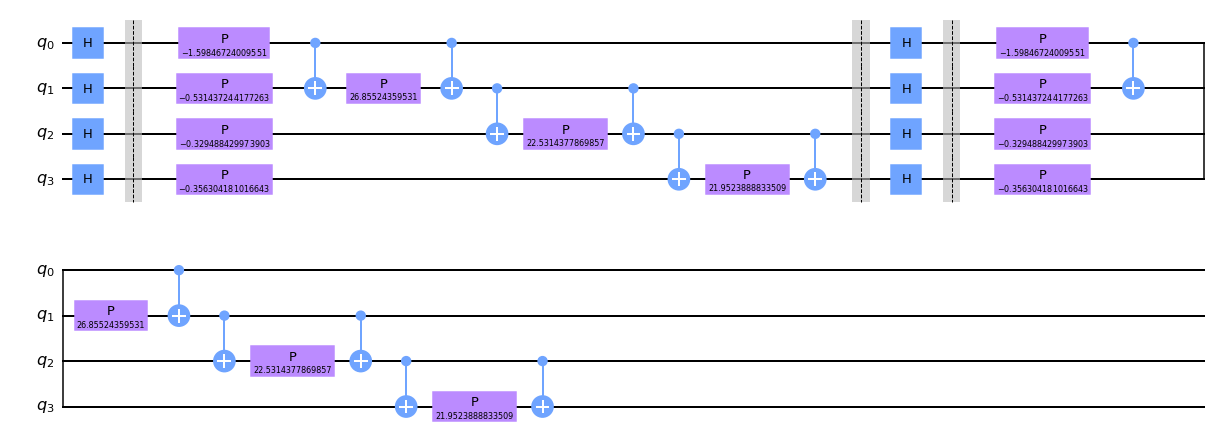

In [61]:
# We have dimensions = 4 because is the number of parameters in sample_train[0]
# so our circuit will have 4 qubits.
# If we consult ZZFeatureMap's features in QisKit we can see: "feature_dimension = Number of features"
encode_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw('mpl')

**Exercise 1: Data Encoding**

Encode the data point $x = (-0.1, 0.2)$ using the `ZZFeatureMap` with 4 repetition and default data mapping function

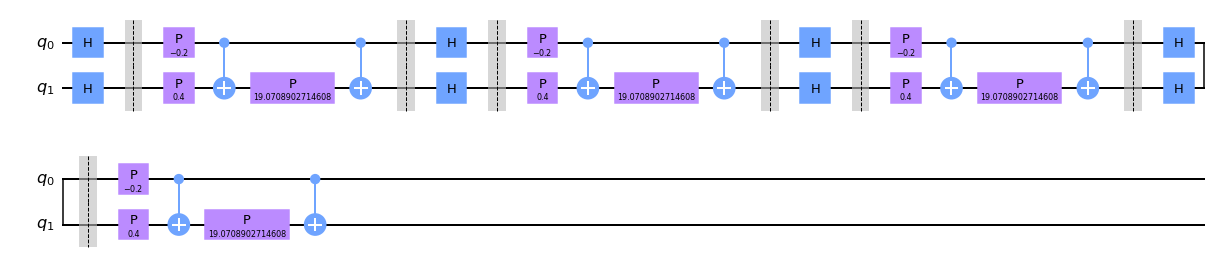

In [62]:
x = [-0.1,0.2]
map1 = ZZFeatureMap(feature_dimension=2, reps=4, entanglement='linear', insert_barriers=True)
circuit1 = map1.bind_parameters(x)
circuit1.decompose().draw('mpl')

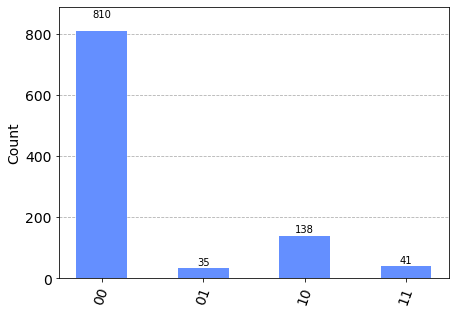

In [63]:
circuit1.measure_all()
backend = Aer.get_backend('qasm_simulator')
job = execute(circuit1, backend, shots = 1024)
results = job.result().get_counts(circuit1)
plot_histogram(results)

## Quantum Kernel Estimation 

A quantum feature map $\varphi(x)$, naturally gives a quantum kernel, $k(X_{i}, x_{j}) = \varphi(x_{j})^{+}\varphi(x_{i})$, which can be seen as a measure of similarity:  $k(x_{i}, x_{j})$ is large when $x_{i}$ and $x_{j}$ are close.

When considering finite data, we can represent quantum kernel as a matrix: $K_{ij} = |\langle \varphi(x_{j})^{+} | \varphi(x_{i}) \rangle |^{2}$. We can calculate each element of this kernel matrix on a quantum computer by calculating the transition amplitude:
$$ |\langle \varphi(x_{j})^{+} | \varphi(x_{i}) \rangle |^{2} = |\langle 0^{\otimes} | U_{\varphi(x_{j})}^{+}U_{\varphi(x_{i})} | 0^{\otimes} \rangle |^{2}$$

assuming the feature map is a parametrized quantum circuit, which can be described as a unitary transformation $U_{\varphi(x)}$ on $n$ qubits.

This provides us with an estimate of the quantum kernel matrix, which we can use in a kernel machine learning algorithm, such a support vector classification.

In [64]:
from qiskit_machine_learning.kernels import QuantumKernel
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map = zz_map, quantum_instance = Aer.get_backend('statevector_simulator'))

In [65]:
# Lets calculate the transition amplitude between the first and the second training data samples, one of the entires in the training kernel matrix
print(sample_train[0])
print(sample_train[1])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]
[-0.81630337 -0.2918343  -0.48757339 -0.44903275]


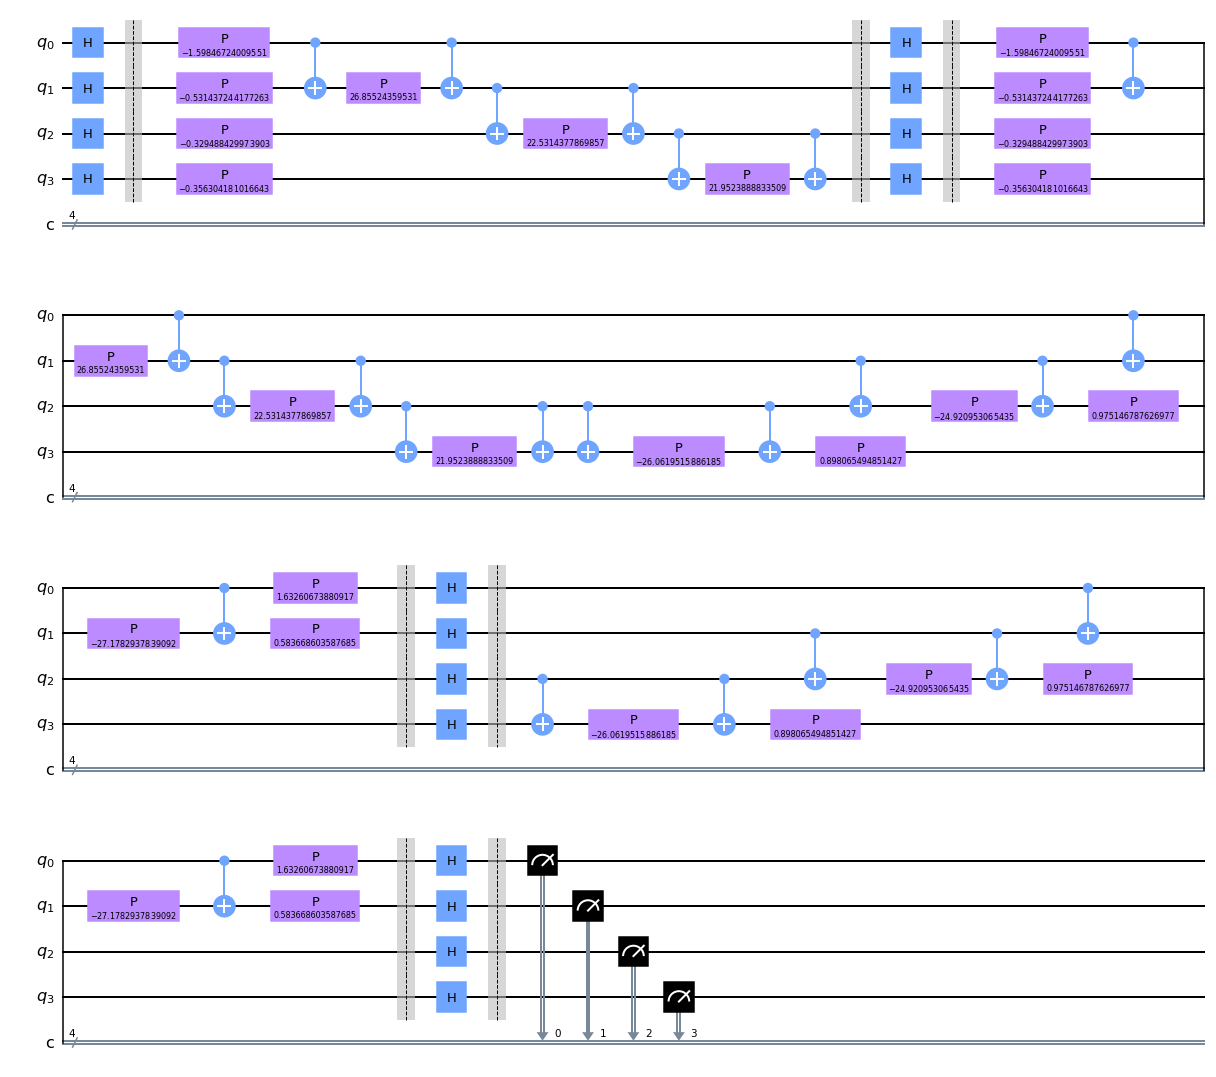

In [66]:
# First we draw the circuit

zz_circuit = zz_kernel.construct_circuit(sample_train[0],sample_train[1])
zz_circuit.decompose().decompose().draw('mpl')

Note that the circuit would be symmetric if the encoding and decoding gates were applied on the same qubits, but since what the kernel does is multiply the operator that acts on the first element with its conjugate on the second element, the first one acts on the first two qubits and the conjugate on the second.

**Now we execute the quantum kernel**

We will use `qasm_simulator` since the circuit contains measurement, but increment the number of shots to reduce the effect of sampling noise.

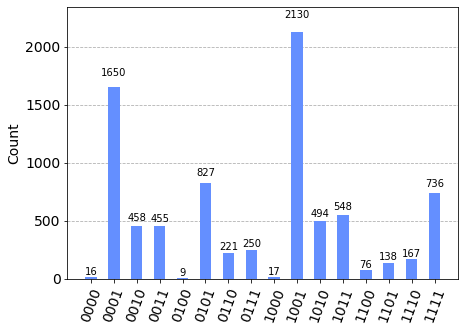

In [67]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192,
              seed_simulator=1024, seed_transpiler=1024)
result = job.result().get_counts(zz_circuit)
plot_histogram(result)

The transition amplitude is the counts in the zero state:

In [68]:
result['0000']/sum(result.values())

0.001953125

This process is then repeat for each pair of training data samples to fill in the training kernel matrix, and between each training and teasting data sample to fill in the teasting kernel matrix. Note that each matrix is symmetric, so to reduce computation time, only half the entries are calculated explicitly. 

Here we compute and plot the training and teasting kernel matrices:

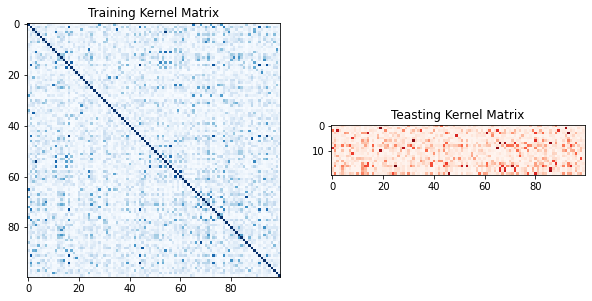

In [69]:
matrix_trian = zz_kernel.evaluate(x_vec= sample_train)
matrix_test = zz_kernel.evaluate(x_vec= sample_test, y_vec= sample_train)

fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].imshow(np.asmatrix(matrix_trian),
              interpolation = 'nearest',
              origin = 'upper',
              cmap = 'Blues')


axs[1].imshow(np.asmatrix(matrix_test),
              interpolation = 'nearest',
              origin = 'upper',
              cmap = 'Reds')

axs[0].set_title('Training Kernel Matrix')
axs[1].set_title('Teasting Kernel Matrix')

plt.show()


**Exercise 2: Quantum Kernel**

Calculate the transition amplitude between $x = (-0.1,0.2)$ and $y = (0.4,-0.6)$ using the `ZZFeaturMap` with 4 repetitions and default data mapping funtion. Use `qasm_simulator` with `shots = 8192`, `seed_simulator = 1024` and `seed_transpiler = 1024`.

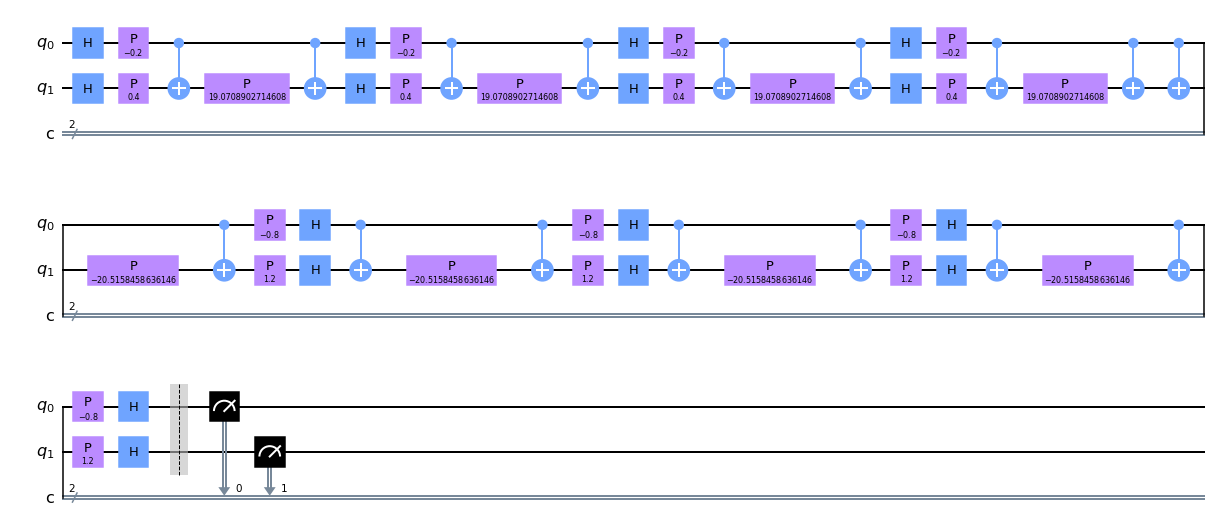

In [70]:
x = [-0.1, 0.2]
y = [0.4,-0.6]

zz_map = ZZFeatureMap(feature_dimension=2, reps=4)
zz_kernel = QuantumKernel(feature_map = zz_map, quantum_instance= Aer.get_backend('qasm_simulator'))
zz_circuit = zz_kernel.construct_circuit(x,y)
zz_circuit.decompose().decompose().draw('mpl')

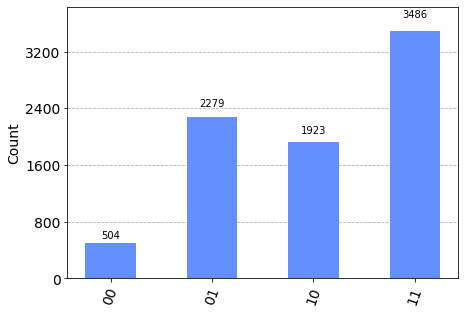

In [71]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192,
              seed_simulator=1024,
              seed_transpiler=1024)
results = job.result().get_counts(zz_circuit)
plot_histogram(results)

In [72]:
show = (results['00']/sum(results.values()))*100
print('The transition probability between x and y is', show, '%')

The transition probability between x and y is 6.15234375 %


## Quantum Support Vector Classification 

<ul> The quantum kernel support vector classification algorithm consists of those steps:
    <li>1. Build the train and test quantum kernel matrices. </li>
        <ul>
            <li>A. For each pair of datapoints in the training dataset $x_{i},x_{j}$, apply the feature map and measure the transition probability: $K_{ij} = |\langle 0^{\otimes} | U_{\varphi(x_{j})}^{+}U_{\varphi(x_{i})} | 0^{\otimes} \rangle |^{2}$</li>
            <li>B. For each training datapoint $x_{i}$ and teasting point $y_{i}$, apply the feature map and measure the transition probability: $K_{ij} = |\langle 0^{\otimes} | U_{\varphi(y_{j})}^{+}U_{\varphi(x_{i})} | 0^{\otimes} \rangle |^{2}$ </li>
        </ul>
    <li>2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm </li>
</ul>

the `scikit-learn scv` algorithm allows us to define a custom kernel in two wys: by providin the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `QuantumKernel` class in `qiskit`.

In [79]:
from sklearn.svm import SVC
zzpc_svc = SVC(kernel = 'precomputed')
zzpc_svc.fit(matrix_trian,label_train)
zzpc_score = zzpc_svc.score(matrix_test,label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.95


In [ ]:
# The following code gives the kernel as a callable function.
# This is convenient as we can easly compare quantum kernel with various classical kernels.
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)
print(f'Callable kernel classification test score: {zzcb_score}')

In [ ]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train,label_train)
    classical_score = classical_svc.score(sample_test,label_test)
    print('%s kernel classification test score: %0.2f' % (kernel,classical_score))

linear kernel classification test score: 1.00
poly kernel classification test score: 0.95
rbf kernel classification test score: 1.00
sigmoid kernel classification test score: 1.00
